In [1]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
from os.path import exists
import cv2

from tensorflow.keras import layers, Model
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

from tensorflow.image import resize
from tensorflow.keras import utils

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.models import Model

from tensorflow.keras.metrics import BinaryIoU

import random

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#!rm -rf /content/data/*.jpg

In [ ]:
# mkdir /content/data

In [ ]:
!pwd

In [ ]:
# #Making directory in collab and moving data from drive to collab
# !cp -rf /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/input_image_train /content/data
# !cp -rf /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/input_image_val /content/data
# !cp -rf /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/input_image_test /content/data
# !cp -rf /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/output_mask_train /content/data
# !cp -rf /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/output_mask_test /content/data
# !cp -rf /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/output_mask_val /content/data

In [ ]:
# #Removing duplicate images
# !rm -rfv /content/data/input_image_train/*\).jpg
# !rm -rfv /content/data/input_image_val/*\).jpg
# !rm -rfv /content/data/input_image_test/*\).jpg
# !rm -rfv /content/data/output_mask_train/*\).jpg
# !rm -rfv /content/data/output_mask_test/*\).jpg
# !rm -rfv /content/data/output_mask_val/*\).jpg

In [2]:
## Data Loader definition

class CustomGen(keras.utils.Sequence):

    def __init__(self, img_path, img_path_mask, batch_size):
        self.img_path = img_path
        self.img_path_mask = img_path_mask
        self.batch_size = batch_size
        self.list_elements = os.listdir(self.img_path)
        self.list_elements_mask = os.listdir(self.img_path_mask)
        #print(self.__dict__)

    def __len__(self):
#         self.list_elements = os.listdir(self.img_path)
#         self.list_elements_mask = os.listdir(self.img_path_mask)
        return len(self.list_elements) // self.batch_size

    def __getitem__(self,idx):        
        X_paths = self.list_elements[idx * self.batch_size:(idx+1) * self.batch_size]
        y_paths = self.list_elements_mask[idx * self.batch_size:(idx+1) * self.batch_size]

        X = []
        y = []

        for x_filename in X_paths:
            img = np.array(utils.load_img(self.img_path + x_filename,
                                 grayscale=False,
                                 color_mode='rgb',
                                 target_size=(256,256),
                                 interpolation='nearest'))


            X.append(img)
            y_filename = x_filename.replace('.jpg','_mask.jpg')
            y_path = self.img_path_mask + y_filename
            file_exists = exists(y_path)
            if file_exists:
                # y.append(load_img('../data/Oil Tanks/image_patches/'+x_filename))
                black_img = np.array(utils.load_img(y_path,
                                 grayscale=False,
                                 color_mode='rgb',
                                 target_size=(256,256),
                                 interpolation='nearest'))
                image_black_resized = black_img[:, :, 0:1]/255.

                image_black_resized[image_black_resized>0.5]=1.
                image_black_resized[image_black_resized<0.5]=0.              
                
                
            else:
#                 import ipdb; ipdb.set_trace()
                image_black_resized = (img*0)[:, :, 0:1]

            y.append(image_black_resized)
        return np.stack(X)/255., np.stack(y)
    
    def on_epoch_end(self):
        random.shuffle(self.list_elements)

In [ ]:
# !pwd

In [ ]:
# loader creation 

# os.chdir('/content/data/')

In [ ]:
 !pwd

In [3]:
# Paths definition after 
img_train_path = '../data/case1_tanks/input_image_train/'
mask_train_path = '../data/case1_tanks/output_mask_train/'

img_val_path = '../data/case1_tanks/input_image_val/'
mask_val_path = '../data/case1_tanks/output_mask_val/'

img_test_path = '../data/case1_tanks/input_image_test/'
mask_test_path = '../data/case1_tanks/output_mask_test/'

# Batch size
batch_size = 8

In [4]:
#Verify files in above directories 
len(os.listdir(mask_test_path))

143

In [5]:
data_loader_train = CustomGen(img_train_path, mask_train_path, batch_size)
data_loader_val = CustomGen(img_val_path, mask_val_path, batch_size)
data_loader_test = CustomGen(img_test_path, mask_test_path, batch_size)

In [6]:
### Test Data loader

In [7]:
#number of images in 1 batch
data_loader_train.__len__()

159

In [8]:
#testing one batches
X,y = data_loader_train.__getitem__(65)

In [9]:
#( batch size, images size, images size, channels)
X.shape, y.shape

((8, 256, 256, 3), (8, 256, 256, 1))

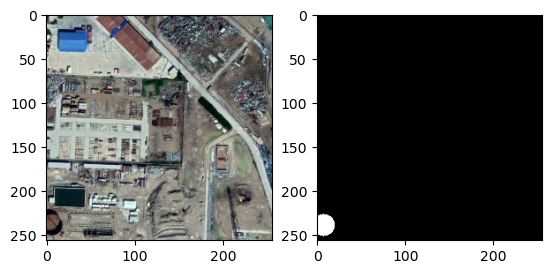

In [10]:
#testing one element of one batches

plt.subplot(1,2,1)
plt.imshow(X[0])

plt.subplot(1,2,2)
plt.imshow(y[0].reshape(256,256), cmap ='gray')

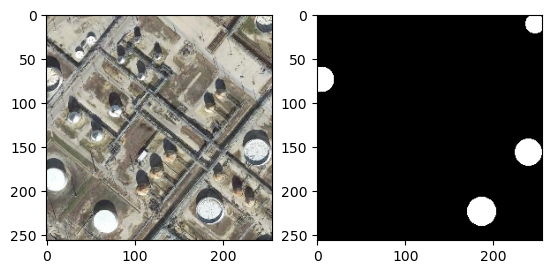

In [16]:
#Shuffle test
data_loader_train.on_epoch_end()
X,y = data_loader_train.__getitem__(65)

#testing one element of one batches

plt.subplot(1,2,1)
plt.imshow(X[0])

plt.subplot(1,2,2)
plt.imshow(y[0].reshape(256,256), cmap ='gray')

In [17]:
# VGG 16 model trans 

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x
 
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
 
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
 
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg16.trainable = False
    
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)
    
    # Freeze the first layer
    # s1.trainable = False
    # s2.trainable = False
    # s3.trainable = False
    # s4.trainable = False
 
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
 
    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
 
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model
 
if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_vgg16_unet(input_shape)
    model.summary()


2022-12-02 13:25:28.437070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:25:28.447296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:25:28.449080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:25:28.451514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [19]:
# Loss function (ref: https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html)
import tensorflow as tf

def custom_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
      y_pred = tf.math.sigmoid(y_pred)
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)

      return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

In [20]:
# Metrices

# meanIou = MeanIoU(num_classes= 1)
BinaryIou = BinaryIoU(target_class_ids=[1], threshold=0.5)

### TEST 11 - VGG Transfer - Binary IOU - Auto learning

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [23]:
# Test-11 Build and fit VGG with custom_loss
input_shape = (256,256,3)
model_11 = build_vgg16_unet(input_shape)
model_11.compile(optimizer="adam", loss = custom_loss , metrics = [BinaryIou, "accuracy"])

In [24]:
es = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
cp = callbacks.ModelCheckpoint('../model/day_5_model/cp_model_11_3.h5', save_best_only=True)
lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=3,
                                verbose=1,
                                mode='auto',
                                min_delta=0.0001,
                                cooldown=0,
                                min_lr=0.000001)

history = model_11.fit(data_loader_train,
          epochs = 100,
          validation_data = data_loader_val,
          callbacks = [es,cp,lr],
          verbose=1)

Epoch 1/100


2022-12-02 13:26:42.596494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


159/159 [==============================] - 72s 384ms/step - loss: 1.5546 - binary_io_u: 0.6830 - accuracy: 0.9759 - val_loss: 1.6189 - val_binary_io_u: 0.4122 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 61s 384ms/step - loss: 1.5336 - binary_io_u: 0.7999 - accuracy: 0.9864 - val_loss: 1.5736 - val_binary_io_u: 0.7083 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 61s 386ms/step - loss: 1.5306 - binary_io_u: 0.8255 - accuracy: 0.9883 - val_loss: 1.5710 - val_binary_io_u: 0.7857 - val_accuracy: 0.9892 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 61s 385ms/step - loss: 1.5304 - binary_io_u: 0.8287 - accuracy: 0.9886 - val_loss: 1.5671 - val_binary_io_u: 0.7781 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 5/100
159/159 [==============================] - 60s 375ms/step - loss: 1.5291 - binary_io_u: 0.8432 - accuracy: 0.9897 - val_loss: 1.5678 - val_binary_io_u: 0.8045 - val_accurac

KeyboardInterrupt: 

In [25]:
# Test-11 loading checkpoint best model

from tensorflow.keras.models import load_model
cp_model_11_3 = load_model('../model/day_5_model/cp_model_11_3.h5', custom_objects={'custom_loss' : custom_loss})

## BEST AS OF TODAY

In [26]:
# Test-11 evaluate on test

cp_model_11_3.evaluate(data_loader_test)

17/17 [==============================] - 3s 159ms/step - loss: 1.5394 - binary_io_u: 0.7981 - accuracy: 0.9873


[1.539446234703064, 0.7980734705924988, 0.9873371124267578]

### Manual Model saving - if required

In [ ]:
# changing directory to save model in Gdrive
# os.chdir('/content/drive/MyDrive/oil-tanker-project/notebooks')

#Saving model in drive
model_fol_path =  '../model/day_5_model'
if not os.path.isdir(model_fol_path):
    os.mkdir(model_fol_path)

#Model Name
model_2.save(model_fol_path + 'model_3.h5')

### EVALUATION

In [ ]:
#checkpoint evaluate <NEED MODEL NAME>

checkpoint_model.evaluate(data_loader_test)

In [ ]:
X_test,y_test = data_loader_test.__getitem__(0)

In [ ]:
#Prediction 1 <NEED MODEL NAME>

y_test_pred = model.predict(X_test)

In [ ]:
data_loader_test.list_elements[4]

In [ ]:
#plt.imshow(X_test[3].reshape(256,256), cmap ='gray')
plt.imshow(y_test[4].reshape(256,256), cmap ='gray')

In [ ]:
c=1
plt.figure(figsize=(10,20))
for i in range(1,8):
  plt.subplot(8,3,c)
  plt.imshow(X_test[i])

  plt.subplot(8,3,c+1)
  plt.imshow(y_test_pred[i].reshape(256,256), cmap ='gray')

  plt.subplot(8,3,c+2)
  plt.imshow(y_test[i].reshape(256,256), cmap ='gray')

  c+=3

In [ ]:
# Prediction 2 <NEED MODEL NAME>
cp_y_test_pred = model_2.predict(X_test)

c=1
plt.figure(figsize=(10,20))
for i in range(1,8):
  plt.subplot(8,3,c)
  plt.imshow(X_test[i])

  plt.subplot(8,3,c+1)
  plt.imshow(cp_y_test_pred[i].reshape(256,256), cmap ='gray')

  plt.subplot(8,3,c+2)
  plt.imshow(y_test[i].reshape(256,256), cmap ='gray')

  c+=3